In [1]:
import pandas as pd
import numpy as np
import os
import re
import math
import socket
import requests

from urllib.parse import urlparse
from bs4 import BeautifulSoup


In [2]:
print(os.listdir("../data"))

legit_raw = pd.read_csv("../data/legitimate_urls.csv")
phish_raw = pd.read_csv("../data/phishing_urls.csv")

print("Legit columns:", legit_raw.columns)
print("Phish columns:", phish_raw.columns)


['legitimate_urls.csv', '.DS_Store', 'phishing_urls.csv', 'final_dataset.csv']
Legit columns: Index(['Unnamed: 0', 'website_url', 'cleaned_website_text', 'Category'], dtype='str')
Phish columns: Index(['phish_id', 'url', 'phish_detail_url', 'submission_time', 'verified',
       'verification_time', 'online', 'target'],
      dtype='str')


In [3]:
legit = legit_raw[['website_url']].copy()
legit.columns = ['url']
legit['label'] = 0

legit.dropna(inplace=True)
legit.drop_duplicates(inplace=True)

phish = phish_raw[['url']].copy()
phish['label'] = 1

phish.dropna(inplace=True)
phish.drop_duplicates(inplace=True)

print("Legitimate URLs:", legit.shape)
print("Phishing URLs:", phish.shape)


Legitimate URLs: (1384, 2)
Phishing URLs: (52809, 2)


In [4]:
min_size = min(len(legit), len(phish))

legit_bal = legit.sample(min_size, random_state=42)
phish_bal = phish.sample(min_size, random_state=42)

data = pd.concat([legit_bal, phish_bal])
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

print("Final dataset shape:", data.shape)
data.head()


Final dataset shape: (2768, 2)


,url,label
0,http://www.wageningenur.nl/en/Expertise-Servic...,0
1,https://www.theworldwomennews.com/,0
2,https://ow.ly/9KPv50Rqj4B,1
3,https://cherished-transform-893212.framer.app,1
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,0


In [5]:
def url_entropy(url):
    probs = [url.count(c)/len(url) for c in set(url)]
    return -sum(p * math.log2(p) for p in probs)

def extract_url_features(url):
    return {
        "url_length": len(url),
        "dot_count": url.count("."),
        "has_ip": int(bool(re.search(r'\d+\.\d+\.\d+\.\d+', url))),
        "has_https": int(url.startswith("https")),
        "has_hyphen": int("-" in urlparse(url).netloc),
        "keyword_count": sum(w in url.lower() for w in ["login","verify","secure","update","bank"]),
        "entropy": url_entropy(url)
    }


In [6]:
def extract_content_features(url):
    features = {
        "has_form": 0,
        "has_password": 0,
        "external_links": 0,
        "urgency_words": 0
    }

    try:
        r = requests.get(url, timeout=5)
        soup = BeautifulSoup(r.text, "html.parser")

        features["has_form"] = int(bool(soup.find("form")))
        features["has_password"] = int(bool(soup.find("input", {"type":"password"})))
        features["external_links"] = len(soup.find_all("a", href=True))
        text = soup.get_text().lower()
        features["urgency_words"] = sum(w in text for w in ["urgent","verify","blocked"])
    except:
        pass

    return features


In [7]:
def get_ip(url):
    try:
        return socket.gethostbyname(urlparse(url).netloc)
    except:
        return None

def extract_network_features(url):
    features = {
        "ip_address": None,
        "protocol": None,
        "server": None,
        "response_code": None,
        "has_hsts": 0,
        "has_x_frame_options": 0,
        "has_x_content_type_options": 0,
        "has_content_security_policy": 0,
        "has_x_xss_protection": 0
    }

    try:
        features["protocol"] = urlparse(url).scheme
        features["ip_address"] = get_ip(url)

        r = requests.get(url, timeout=5)
        features["response_code"] = r.status_code
        features["server"] = r.headers.get("Server")

        headers = r.headers
        features["has_hsts"] = int("Strict-Transport-Security" in headers)
        features["has_x_frame_options"] = int("X-Frame-Options" in headers)
        features["has_x_content_type_options"] = int("X-Content-Type-Options" in headers)
        features["has_content_security_policy"] = int("Content-Security-Policy" in headers)
        features["has_x_xss_protection"] = int("X-XSS-Protection" in headers)

    except:
        pass

    return features


In [8]:
rows = []

for _, row in data.iterrows():
    f = extract_url_features(row['url'])
    f.update(extract_content_features(row['url']))
    f.update(extract_network_features(row['url']))
    f['label'] = row['label']
    rows.append(f)

df = pd.DataFrame(rows)
df.head()


,url_length,dot_count,has_ip,has_https,has_hyphen,keyword_count,entropy,has_form,has_password,external_links,...,ip_address,protocol,server,response_code,has_hsts,has_x_frame_options,has_x_content_type_options,has_content_security_policy,has_x_xss_protection,label
0,113,3,0,0,0,0,4.578096,0,0,0,...,137.224.9.30,http,NaN,NaN,0,0,0,0,0,0
1,34,2,0,1,0,0,3.777777,0,0,4,...,76.223.105.230,https,DPS/2.0.0+sha-57bdacc,200.0,1,0,0,1,0,0
2,25,1,0,1,0,0,4.373661,0,0,103,...,3.215.84.252,https,Vercel,200.0,1,1,1,1,0,1
3,45,2,0,1,1,0,4.333209,0,0,0,...,52.223.52.2,https,Framer/09aad95,404.0,1,0,1,0,0,1
4,127,5,0,1,0,0,5.286425,0,0,1,...,23.206.173.43,https,istio-envoy,429.0,1,1,1,1,1,0


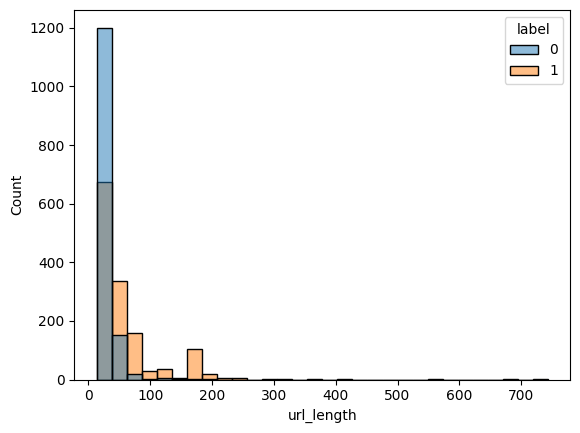

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df, x="url_length", hue="label", bins=30)
plt.show()


In [11]:
df.dtypes


url_length                       int64
dot_count                        int64
has_ip                           int64
has_https                        int64
has_hyphen                       int64
keyword_count                    int64
entropy                        float64
has_form                         int64
has_password                     int64
external_links                   int64
urgency_words                    int64
ip_address                         str
protocol                           str
server                             str
response_code                  float64
has_hsts                         int64
has_x_frame_options              int64
has_x_content_type_options       int64
has_content_security_policy      int64
has_x_xss_protection             int64
label                            int64
dtype: object

In [12]:
# Drop non-numeric (string) columns
df = df.drop(columns=["ip_address", "protocol", "server"])


In [13]:
import pandas as pd

df = df.apply(pd.to_numeric, errors="coerce")
df = df.dropna()


In [14]:
df.dtypes


url_length                       int64
dot_count                        int64
has_ip                           int64
has_https                        int64
has_hyphen                       int64
keyword_count                    int64
entropy                        float64
has_form                         int64
has_password                     int64
external_links                   int64
urgency_words                    int64
response_code                  float64
has_hsts                         int64
has_x_frame_options              int64
has_x_content_type_options       int64
has_content_security_policy      int64
has_x_xss_protection             int64
label                            int64
dtype: object

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = df.drop("label", axis=1)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

pred = model.predict(X_test)
print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.92      0.88      0.90        26
           1       0.85      0.89      0.87        19

    accuracy                           0.89        45
   macro avg       0.89      0.89      0.89        45
weighted avg       0.89      0.89      0.89        45



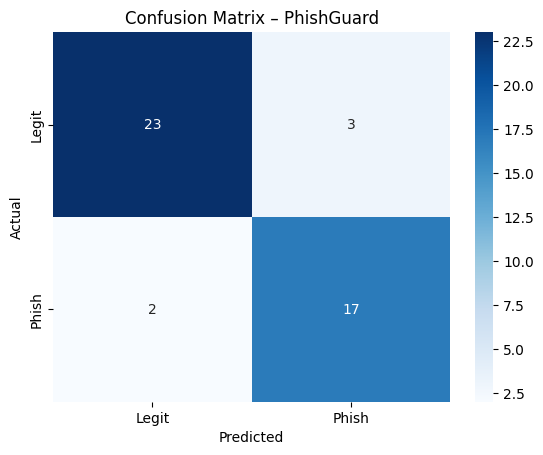

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Legit", "Phish"],
            yticklabels=["Legit", "Phish"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – PhishGuard")
plt.show()


In [17]:
df.to_csv("../data/final_dataset.csv", index=False)

import joblib
joblib.dump(model, "../src/phish_model.pkl")


['../src/phish_model.pkl']